In [8]:
using JSON
using MultivariateStats
using RDatasets 
using Distributions
using Random
using PyPlot
using Clustering
using LinearAlgebra


dpath = "../dataset_json/"

# number of patients
n  = 5366
s  = 750

5366

In [2]:
# looking at single patient file
p1 = JSON.parsefile(dpath * "patient_1.json")

Dict{String,Any} with 8 entries:
  "num_observations" => 74
  "mortality"        => true
  "patient_index"    => 1
  "actions"          => Any[21, 21, 1, 1, 1, 1, 1, 1, 1, 21  …  1, 1, 1, 1, 2, …
  "icuid"            => 200003
  "MAP"              => Any[83, 84.5, 68.2, 69.3333, 70, 73, 66, 68, 71, 72  … …
  "cont_actions"     => Any[Any[0.2245, 0.224, 0, 0, 0, 0, 0, 0, 0, 0.225  …  0…
  "trajectory"       => Any[Any[-0.359482, 0.439907, -1.05909, -0.487919, -0.17…

In [3]:
# trajectory size
size(p1["trajectory"][1])

(49,)

In [4]:
# adding all states for all patients into 
# single array to find clusters
states = []
for i = 1:n
    p     = JSON.parsefile(dpath * "patient_" * string(i) * ".json")
    τ     = p["trajectory"]
    τ_len = size(τ)[1] 
    for j = 1:τ_len
       push!(states, τ[j]) 
    end
end
# form state matrix, columns are 49-vectors of states
S = hcat(states...)
size(S)

(49, 352328)

(49, 351975)(49, 353)
(

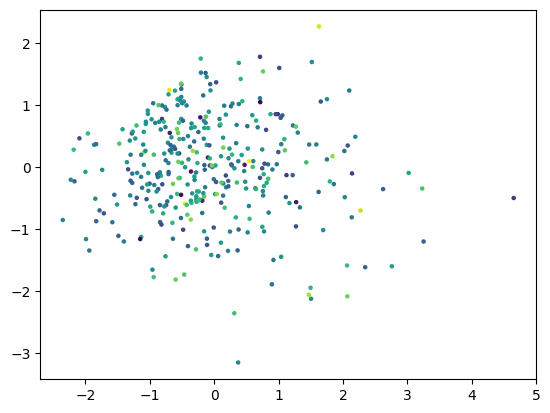

3, 353)
(49, 353)


In [54]:
# reducing dimentionality of state space for 
# visualization
function partition_train_test(data, at = 0.999)
    n         = size(data, 2)
    idx       = shuffle(1:n)
    
    train_idx = view(idx, 1:floor(Int, at * n))    
    test_idx  = view(idx, (floor(Int, at * n) + 1):n)
    
    return data[:,train_idx], data[:,test_idx]
end

train, test = partition_train_test(S)
println(size(train), size(test))

M = fit(PCA, train; maxoutdim = 3)

# apply PCA model to testing set
y_te = MultivariateStats.transform(M, test)

# reconstruct testing observations (approximately)
test_2d = reconstruct(M, y_te)
println(size(y_te))
println(size(test_2d))

scatter(y_te[1,:],y_te[2,:], c = y_te[3,:], s = 5)
plt.show()


In [55]:
function distance(p1, p2) 
    return sum((p1 - p2).^2) 
end
   
function k_means_pp(data, k)
    dim      = size(data)[1]
    m        = size(data)[2]

    centroids = []
    push!(centroids, data[1:dim, rand(1:m)])
       
    for i = 1:(k - 1)
        dist = []

        for s = 1:m
            p = data[:, s]
            d = Float64(Inf)

            for j = 1:size(centroids)[1]
                p_dist = distance(p, centroids[j])
                d = min(d, p_dist)
            end
            push!(dist, d)
        end
        
        # add next centroid
        push!(centroids, data[1:dim, argmax(dist)])
    end
    
    return centroids 
end

k_means_pp (generic function with 1 method)

In [56]:
function plot(data, centroids = missing)
    
    scatter(data[1,:], data[2,:], color = "gray")
    
    if !ismissing(centroids)
        scatter(centroids[1,:], centroids[2,:], color = "red")
    end
    
    legend()
    ylim(-50, 50)
    xlim(-50, 50)

    plt.show()
end

plot (generic function with 2 methods)

In [ ]:
centroids = k_means_pp(S, 750)
vc        = hcat(centroids...)
R         = kmeans!(data, vc)

plot(train, vc) 